In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/datasets/distilbert_results

/content/drive/MyDrive/datasets/distilbert_results


In [4]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf
import kerastuner as kt

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## to load ingredients
if you want to train the rnn using the ingredients rather than the recipes themselves.

In [ ]:
ingredients = pd.read_csv('/content/drive/MyDrive/datasets/distilbert_results/ner_ingredients.csv')
labels = pd.read_csv('/content/drive/MyDrive/datasets/distilbert_results/ner_labels.csv')
recipes = pd.read_csv('/content/drive/MyDrive/datasets/distilbert_results/ner_recipes.csv')

In [ ]:
ingredients.head()

,ingredients
0,mango juice
1,pinch salt
2,rout
3,rill grate
4,dill gherkin


In [ ]:
labels.head()

,Vegetarian,Vegetarian&Desserts
0,0,1
1,0,0
2,0,0
3,1,1
4,0,1


In [ ]:
recipes.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,banana,sugar,cinnamon,vanilla ice cream,bourbon,butter,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mash potato,milk,tomato,beef broth,rosemary leave,skirt steak,pepper,butter,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clove,jalapeno,ginger,bourbon,apple cider,lemon,anise,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,soy sauce,sugar,sesame oil,asparagus,sesame seed,wine vinegar,kosher salt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,egg,baking soda,sugar,flour,cream,confectioner,cream cheese,beer,stick butter,cupcake,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
recipes_lst = [ [item for item in row if not pd.isna(item)] for row in recipes.values ]

In [ ]:
recipes_lst[0]

['banana', 'sugar', 'cinnamon', 'vanilla ice cream', 'bourbon', 'butter']

In [ ]:
labels_lst = labels['Vegetarian&Desserts'].values

In [ ]:
type(labels_lst)

numpy.ndarray

## to load recipes
if you want to train the rnn using the recipes

In [6]:
data = pd.read_csv('/content/drive/MyDrive/datasets/recipes_df_10k_balanced.csv')

In [7]:
data.head()

,cooking_method,ingredients,recipe_name,tags,Vegetarian&Desserts,Others&D,Vegetarian,Others,Dairy Free,Gluten Free,Low Carb,Low Fat,Low Sodium
0,['Melt the butter in a saute pan over medium-h...,"['1/4 cup unsalted butter', '2/3 cup brown sug...",Bardstown Distillery Bananas Foster,"Bananas Foster,Banana,Fruit,Bourbon,Dessert,Gl...",1,0,0,1,0,1,0,0,1
1,"['Add broth, sun-dried tomatoes, and butter to...","['1 2/3 cups canned beef broth', '3/4 cup read...",Steak Pinwheels with Sun-Dried Tomato Stuffing...,"Steak,Beef,Meat",0,1,0,1,0,0,0,0,0
2,"['Using a peeler, remove the zest from 1 lemon...","['2 lemons', '4 cups apple cider', 'One 12-oun...",Spiced Bourbon-Ginger Cider,"Bourbon,Fruit,Lemon,Low-Fat,Low Sodium",0,1,0,1,0,0,0,1,1
3,['Bring a large pot of water to a rolling boil...,"['3 tablespoons sesame oil', '2 tablespoons wh...",Asparagus Spears with Sesame,"Vegetarian,Asparagus,Vegetable,Vegan",1,0,1,0,0,0,0,0,0
4,"['Preheat oven to 350 degrees F.', 'In a large...","['3/4 cup unsweetened cocoa, plus more for dus...",Chocolate Stout Cupcakes,"Easy Dessert Recipes,Dessert,Easy,Easy Baking,...",1,0,0,1,0,0,0,0,1


In [8]:
recipes = data['cooking_method']
labels = data['Vegetarian&Desserts']

In [21]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5000, 1: 5000}
{0: 4000, 1: 4000}
{0: 1000, 1: 1000}


In [22]:
# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Get GPU details if available
if tf.config.list_physical_devices('GPU'):
    gpu_info = tf.config.list_physical_devices('GPU')[0]
    print("GPU Name:", gpu_info.name)

TensorFlow version: 2.15.0
Num GPUs Available:  1
GPU Name: /physical_device:GPU:0


## training the rnn

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(recipes)  # Fit the tokenizer on the texts

sequences = tokenizer.texts_to_sequences(recipes)

In [25]:
vocab_size = len(tokenizer.word_index) + 1

In [26]:
max_length = max(len(x) for x in sequences)
recipes_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', dtype='float32', value=0.0)  # Post-padding with zeros

In [27]:
recipes_sequences.shape

(10000, 2123)

In [67]:
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(recipes_sequences, labels, test_size=0.3, random_state=42, stratify=labels)

In [30]:
# Define model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=768, input_length=2123),
    Bidirectional(LSTM(256)),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Assuming X_train and y_train are your data prepared as sequences and labels respectively
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2123, 768)         9149184   
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               2099200   
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 11248897 (42.91 MB)
Trainable params: 11248897 (42.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
88/88 [==============================] - 64s 675ms/step - loss: 0.5934 - accuracy: 0.6852 - val_loss: 0.5388 - val_accuracy: 0.7314
Epoch 2/10
88/88 [==============================] - 58s 655ms/step 

In [ ]:
# Define model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=43),
    Bidirectional(LSTM(1)),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Assuming X_train and y_train are your data prepared as sequences and labels respectively
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 43, 100)           598300    
                                                                 
 bidirectional_14 (Bidirect  (None, 2)                 816       
 ional)                                                          
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
Total params: 599119 (2.29 MB)
Trainable params: 599119 (2.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
171/171 [==============================] - 16s 52ms/step - loss: 0.6581 - accuracy: 0.6341 - val_loss: 0.5584 - val_accuracy: 0.7449
Epoch 2/10
171/171 [==============================] - 4s 23ms/step - lo

In [ ]:
# Assuming X_test is prepared and ready
predictions = model.predict(X_test)
# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
print("Confusion Matrix:\n", conf_matrix)


92/92 [==============================] - 18s 164ms/step
Accuracy: 0.7529853292391675
Precision: 0.7307692307692307
Recall: 0.8087837837837838
F1 Score: 0.7677998717126363
Confusion Matrix:
 [[1010  441]
 [ 283 1197]]


## hyperparameter tuning

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Int('embedding_dim', min_value=32, max_value=512, step=32), input_length=43))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), dropout=hp.Float('dropout', 0, 0.5, step=0.1))))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='results',
    project_name='RNN_hlt')

tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

Trial 10 Complete [00h 01m 24s]
val_accuracy: 0.7997075915336609

Best val_accuracy So Far: 0.8011695742607117
Total elapsed time: 00h 15m 28s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
trials = tuner.oracle.get_best_trials()
for trial in trials:
    print('Trial ID:', trial.trial_id)
    print('Score:', trial.score)
    print('Hyperparameters:', trial.hyperparameters.values)


Trial ID: 06
Score: 0.8011695742607117
Hyperparameters: {'embedding_dim': 224, 'units': 192, 'dropout': 0.30000000000000004, 'learning_rate': 0.003814120220610665}


In [ ]:
# Assuming X_test is prepared and ready
predictions = best_model.predict(X_test)
# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
print("Confusion Matrix:\n", conf_matrix)


92/92 [==============================] - 2s 6ms/step
Accuracy: 0.7809621289662231
Precision: 0.7648546144121365
Recall: 0.8175675675675675
F1 Score: 0.7903331156107121
Confusion Matrix:
 [[1079  372]
 [ 270 1210]]


## adding an attention layer

In [48]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="orthogonal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Applying a simple attention mechanism
        e = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = inputs * a
        return tf.reduce_sum(output, axis=1)

    def get_config(self):
        return super(AttentionLayer, self).get_config()


In [76]:
embedding_dim = 512
lstm_units = 32

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=2123),
    Bidirectional(LSTM(lstm_units, dropout=0.3, return_sequences=True)),  # Ensure return_sequences is True for attention
    BatchNormalization(),
    AttentionLayer(),
    Dense(1, activation='sigmoid')
])

optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 2123, 512)         6099456   
                                                                 
 bidirectional_14 (Bidirect  (None, 2123, 64)          139520    
 ional)                                                          
                                                                 
 batch_normalization_11 (Ba  (None, 2123, 64)          256       
 tchNormalization)                                               
                                                                 
 attention_layer_12 (Attent  (None, 64)                2187      
 ionLayer)                                                       
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                     

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X_train_C, y_train_C, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    min_delta=0.001,       # Minimum change to qualify as an improvement
    patience=5,            # Number of epochs to wait for improvement
    verbose=1,             # Output messages
    mode='min',            # Stops training when the quantity monitored stops decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Train the model with the EarlyStopping callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
175/175 [==============================] - 115s 206ms/step - loss: 0.5482 - accuracy: 0.7018 - val_loss: 0.6250 - val_accuracy: 0.6443
Epoch 2/10
175/175 [==============================] - 29s 165ms/step - loss: 0.3952 - accuracy: 0.8250 - val_loss: 0.4594 - val_accuracy: 0.8243
Epoch 3/10
175/175 [==============================] - 28s 160ms/step - loss: 0.3408 - accuracy: 0.8473 - val_loss: 0.4805 - val_accuracy: 0.7414
Epoch 4/10
175/175 [==============================] - 27s 154ms/step - loss: 0.2989 - accuracy: 0.8686 - val_loss: 0.4301 - val_accuracy: 0.8207
Epoch 5/10
175/175 [==============================] - 26s 148ms/step - loss: 0.2686 - accuracy: 0.8871 - val_loss: 0.4385 - val_accuracy: 0.8250
Epoch 6/10
175/175 [==============================] - 26s 147ms/step - loss: 0.2314 - accuracy: 0.9018 - val_loss: 0.5243 - val_accuracy: 0.8079
Epoch 7/10
175/175 [==============================] - 25s 144ms/step - loss: 0.1983 - accuracy: 0.9154 - val_loss: 0.4934 - val_a

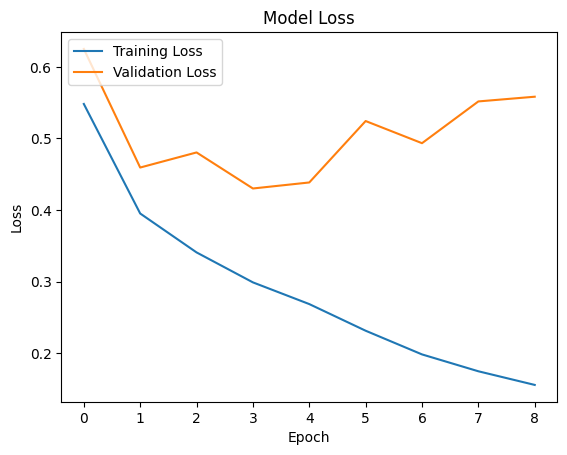

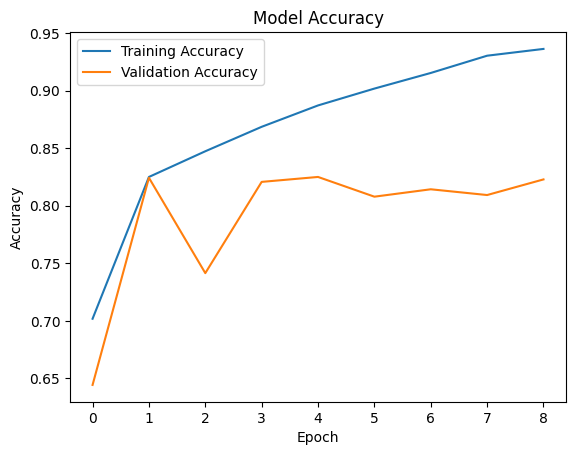

In [78]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [81]:
predictions = model.predict(X_test_C)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_C, binary_predictions)
precision = precision_score(y_test_C, binary_predictions)
recall = recall_score(y_test_C, binary_predictions)
f1 = f1_score(y_test_C, binary_predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_C, binary_predictions)
print("Confusion Matrix:\n", conf_matrix)


94/94 [==============================] - 5s 56ms/step
Accuracy: 0.819
Precision: 0.800376647834275
Recall: 0.85
F1 Score: 0.8244422890397672
Confusion Matrix:
 [[1182  318]
 [ 225 1275]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.initializers import GlorotUniform, HeNormal

model = Sequential([
    Embedding(input_dim=10000, output_dim=512, input_length=2123, embeddings_initializer=GlorotUniform()),
    Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=GlorotUniform(), recurrent_initializer='orthogonal')),
    Dense(1, activation='sigmoid', kernel_initializer=HeNormal())
])

X_train, X_val, y_train, y_val = train_test_split(X_train_C, y_train_C, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    min_delta=0.001,       # Minimum change to qualify as an improvement
    patience=5,            # Number of epochs to wait for improvement
    verbose=1,             # Output messages
    mode='min',            # Stops training when the quantity monitored stops decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Train the model with the EarlyStopping callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stopping]
)
